starting training
 loss: 7.322485446929932Epoch 1/1, Loss: 1.1416


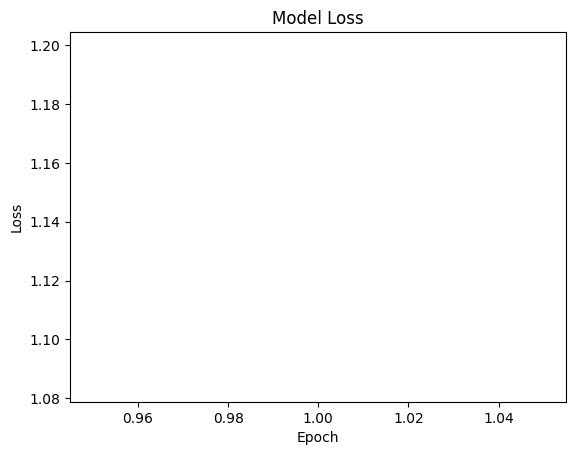

In [38]:
import torch
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
dataset = load_dataset('bigscience/P3', 'cos_e_v1.11_aligned_with_common_sense')
train_dataset = dataset['train']

# Initialize the tokenizer and model
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Define the soft prompt
L = 20
d = model.model.shared.embedding_dim
soft_prompt = torch.nn.Parameter(torch.randn(L, d))
optimizer = AdamW([soft_prompt])

# Training parameters
epochs = 1
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
soft_prompt.to(device)

print('starting training')

# Training loop
losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(train_dataset) - 9000, batch_size):
        batch = train_dataset[i:i+batch_size]
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids 
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        # Get the input embeddings
        input_embeddings = model.model.shared(input_ids)

        soft_prompt_batch = soft_prompt.unsqueeze(0).repeat(input_embeddings.size(0), 1, 1).to(device)
        combined_embeddings = torch.cat([soft_prompt_batch, input_embeddings], dim=1)

        # Pass the combined embeddings through the model
        outputs = model(inputs_embeds=combined_embeddings, labels=labels)
        # print(f'inpute embeddings shape: {input_embeddings.shape}')
        # print(f'combined embeddings shape: {combined_embeddings.shape}')
        # print(f'outputs shape: {outputs.logits.shape}')
        # print(f'labels shape: {labels.shape}')
        # print(f'labels: {labels}')
        # print(f'labels pretokenized: {batch["targets_pretokenized"]}')
        loss = outputs.loss
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'\r complete from this epoch {i}/{len(train_dataset)}', end='')
        print(f'\r loss: {loss.item()}', end='')


    epoch_loss /= len(train_dataset)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}')


# Create a DataFrame with epoch and loss data
loss_data = pd.DataFrame({'Epoch': range(1, epochs + 1), 'Loss': losses})

# Plot loss over time using Seaborn
sns.lineplot(data=loss_data, x='Epoch', y='Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
prompt_list = [
    'When you see the following question, I would like you to answer it correctly', # ~13 tokens 
    'Produce an executable artifact of type X that will answer the question, and then execute it',
    'When I ask you a question, generate three additional questions that would help you give a more accurate answer. When you then answered the three questions, combine the answers to produce the final answers to my original question',
    'Generate a set of facts that are contained in the output. The set of facts should be inserted in a specific point in the output to answer the question',
]